In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
import datetime
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import prettyplotlib as ppl
import brewer2mpl
import random
from operator import itemgetter
import time
import copy

In [4]:
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 16,
        }
plt.rc('font',family='serif')
plt.rc('font', size=16)
plt.rc('font', weight='bold')
plt.style.use('fivethirtyeight')
    
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 6 and height to 6
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

In [5]:
train = pd.read_csv('data/act_train.csv', dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8}, parse_dates=['date'])
test = pd.read_csv('data/act_test.csv', dtype={'people_id': np.str,
                              'activity_id': np.str}, parse_dates=['date'])
people = pd.read_csv('data/people.csv', dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},parse_dates=['date'])

In [6]:
print("Process tables...")
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type -999', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)

Process tables...


In [7]:
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
        people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
        people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)

print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(-999, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(-999, inplace=True)

Merge...


In [8]:
feature_cols = [col for col in train.columns if col not in ['people_id', 'activity_id','outcome']]
target = 'outcome'

In [9]:
print('Length of train: ', len(train))
print('Length of test: ', len(test))
print('Features [{}]: {}'.format(len(feature_cols), sorted(feature_cols)))


Length of train:  2197291
Length of test:  498687
Features [56]: ['activity_category', 'char_10_x', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_1_x', 'char_1_y', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_2_x', 'char_2_y', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38', 'char_3_x', 'char_3_y', 'char_4_x', 'char_4_y', 'char_5_x', 'char_5_y', 'char_6_x', 'char_6_y', 'char_7_x', 'char_7_y', 'char_8_x', 'char_8_y', 'char_9_x', 'char_9_y', 'day_x', 'day_y', 'group_1', 'month_x', 'month_y', 'year_x', 'year_y']


In [10]:
def plot_roc(model, title):
    model.fit(X_train, y_train)
    actuals = y_train
    predictions  = model.predict(X_train)
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(actuals, predictions)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    actuals_t = y_test
    predictions_t  = model.predict(X_test)
    false_positive_rate_t, true_positive_rate_t, thresholds_t = metrics.roc_curve(actuals_t, predictions_t)
    roc_auc_t = metrics.auc(false_positive_rate_t, true_positive_rate_t)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, 'r', label='Training = %0.2f'% roc_auc)
    plt.plot(false_positive_rate_t, true_positive_rate_t, 'g', label='Test = %0.2f'% roc_auc_t)
    plt.fill(false_positive_rate, true_positive_rate, facecolor='blue', alpha=0.5, )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontdict=font)
    plt.ylabel('True Positive Rate', fontdict=font)
    title = "Redhat Dataset " + title
    plt.title(title, fontdict=font)
    plt.legend(loc="lower right", fontsize=20)
    #plt.savefig(name, bbox_inches='tight')
    plt.show()
    return roc_auc 

In [11]:
model = ensemble.RandomForestClassifier()

In [12]:
X = train[feature_cols]
Xt = test[feature_cols]
y = train['outcome']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 56)
(1757832,)


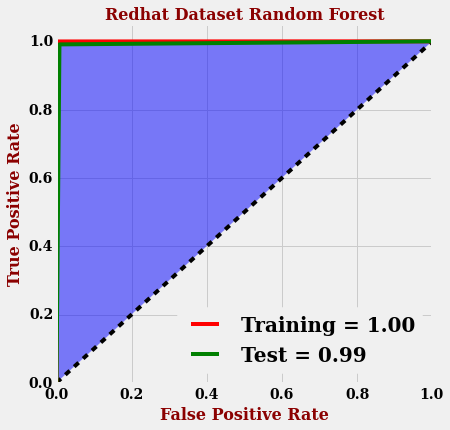

0.99968119361478325

In [16]:
plot_roc(model, "Random Forest")

In [17]:
X = train[feature_cols]
Xt = test[feature_cols]
y = train['outcome']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(1757832, 56)
(1757832,)


In [ ]:
%%time
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble
grid = GridSearchCV(ensemble.RandomForestClassifier(), param_grid={'criterion':['gini','entropy'],
        'min_samples_split':[1,2,6,10],'n_estimators': [1000, 1500, 2000],'max_features': ['auto']}, 
                     scoring='recall', cv=3, n_jobs=-1)

# fit out model
grid.fit(X_train, y_train)

In [55]:
print(model)
print("")
# fit the model
model.fit(X, y)
# summarize the fit of the model
score = model.score(X, y)
print("Classification score using train set: {}\n".format(str(score)))
pd.DataFrame(model.feature_importances_,index=X.columns).sort([0], ascending=False) [:]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Classification score using train set: 0.97158455571



/usr/local/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,0
group_1,0.492977
char_38,0.342297
char_2_y,0.164726


In [39]:
y_predict = lr.predict_proba(Xt)

In [40]:
print(y_predict)

[[ 0.48430903  0.51569097]
 [ 0.48430903  0.51569097]
 [ 0.16378287  0.83621713]
 ..., 
 [ 0.71886696  0.28113304]
 [ 0.71886696  0.28113304]
 [ 0.76166601  0.23833399]]


In [41]:
yPred = y_predict[:,1]

In [42]:
current_time = datetime.datetime.now()

In [43]:
sub = pd.DataFrame()
sub['activity_id'] = test['activity_id']
sub['outcome'] = yPred.tolist()
sub.to_csv('submission_Lr_' + str(current_time.strftime("%Y-%m-%d-%H-%M")) + '.csv', index=False)